In [271]:
# !pip install qiskit pylatexenc qiskit-aer

In [272]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

import numpy as np

In [273]:

# ================================
# STEP 1: Setup circuit
# ================================

q_reg = QuantumRegister(3, name="data")
q_reg_ancilla = QuantumRegister(2, name="ancilla")
c_reg = ClassicalRegister(2, name="syndrome")
c_reg_result = ClassicalRegister(1, name="result")

qc = QuantumCircuit(q_reg, q_reg_ancilla, c_reg, c_reg_result)


# ================================
# STEP 2: Initial State
# ================================
u = np.random.uniform(0, 1)
theta = np.arccos(u)
qc.ry(theta, q_reg[0])
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

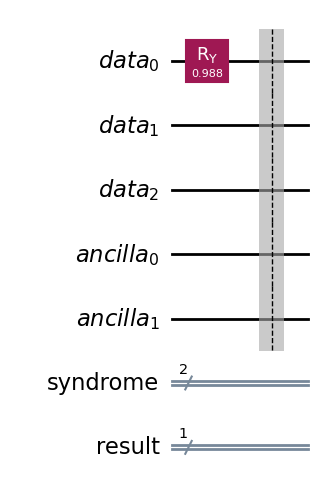

In [274]:

qc.barrier()
qc.draw("mpl")

In [275]:

# ================================
# STEP 3: Encoding
# ================================

qc.cx(q_reg[0], q_reg[1])
qc.cx(q_reg[0], q_reg[2])
qc.barrier()

Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

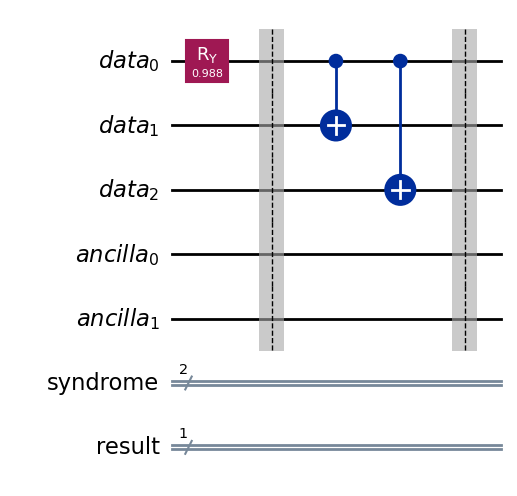

In [276]:
qc.draw("mpl")

No error injected.


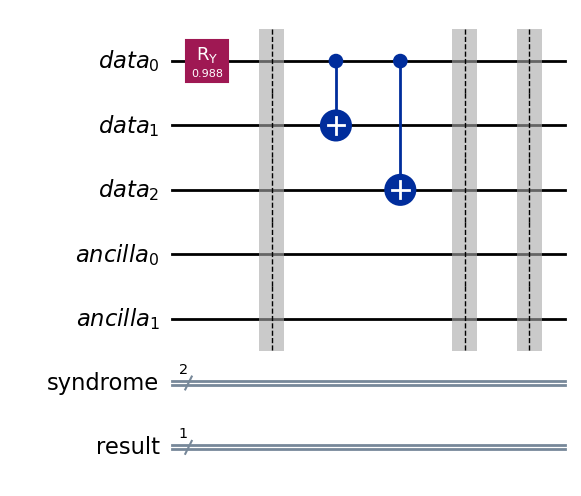

In [277]:

# ================================
# STEP 4: Error Injection
# ================================
error_circ = QuantumCircuit(3)
ind = np.random.randint(0, 4)
if ind > 0:
    error_circ.x(ind-1)
    print(f"Bit-flip Error (x) injected on Qubit: {ind-1}")
else:
    print("No error injected.")

qc.compose(error_circ, q_reg, inplace=True)
qc.barrier()
qc.draw("mpl")

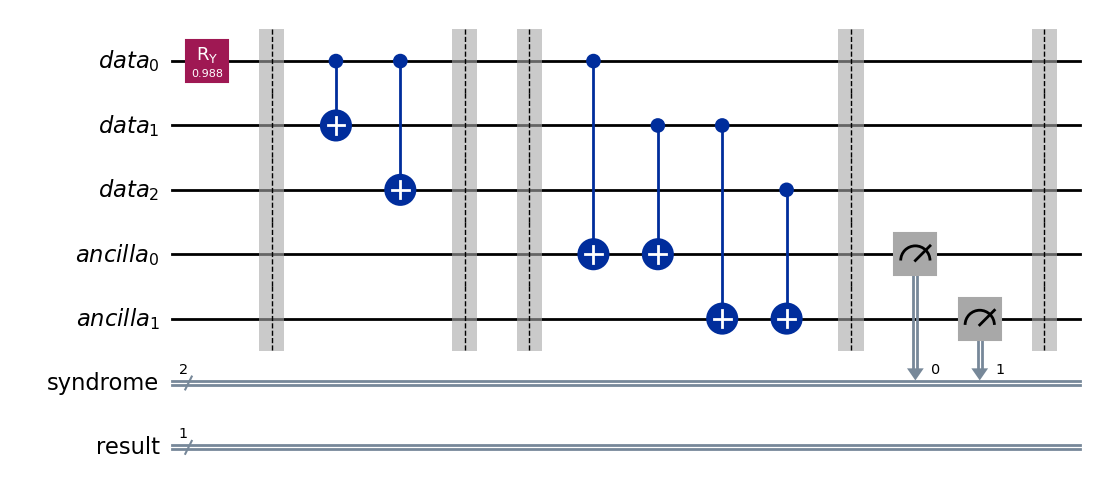

In [278]:

# ================================
# STEP 5: Syndrome Extraction
# ================================

qc.cx(q_reg[0], q_reg_ancilla[0])
qc.cx(q_reg[1], q_reg_ancilla[0])
qc.cx(q_reg[1], q_reg_ancilla[1])
qc.cx(q_reg[2], q_reg_ancilla[1])
qc.barrier()

qc.measure(q_reg_ancilla[0], c_reg[0])
qc.measure(q_reg_ancilla[1], c_reg[1])

qc.barrier()
qc.draw("mpl")

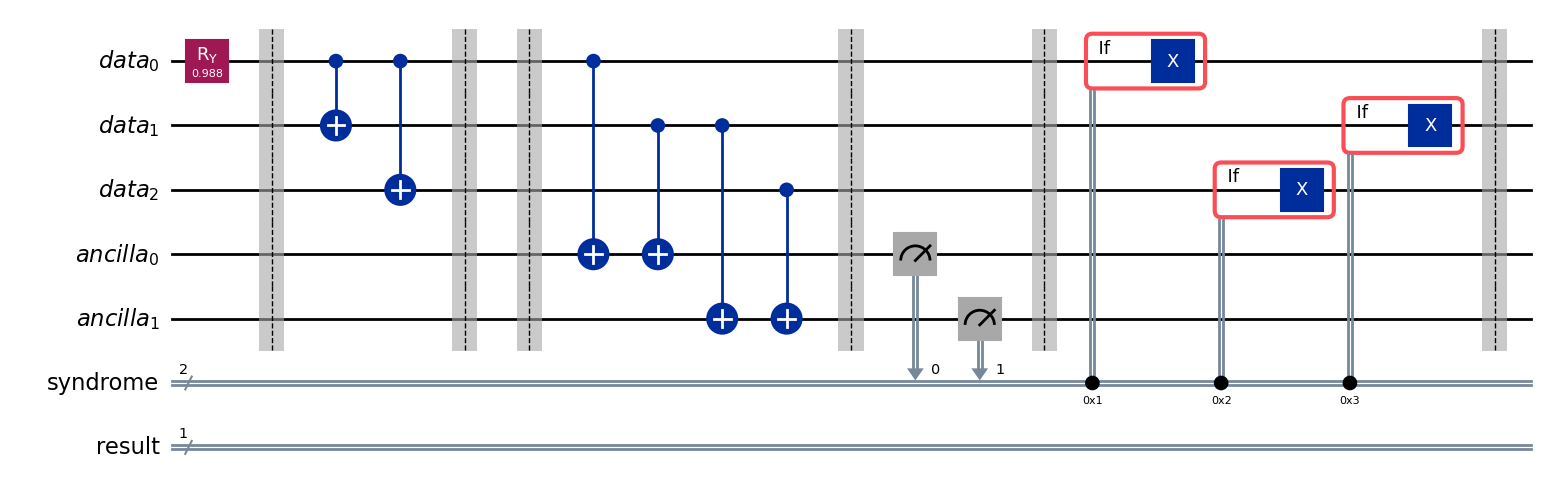

In [279]:

# ================================
# STEP 6: Decoding
# ================================
with qc.if_test((c_reg, 1)):
    qc.x(q_reg[0])
with qc.if_test((c_reg, 2)):
    qc.x(q_reg[2])
with qc.if_test((c_reg, 3)):
    qc.x(q_reg[1])
qc.barrier()

qc.draw("mpl")

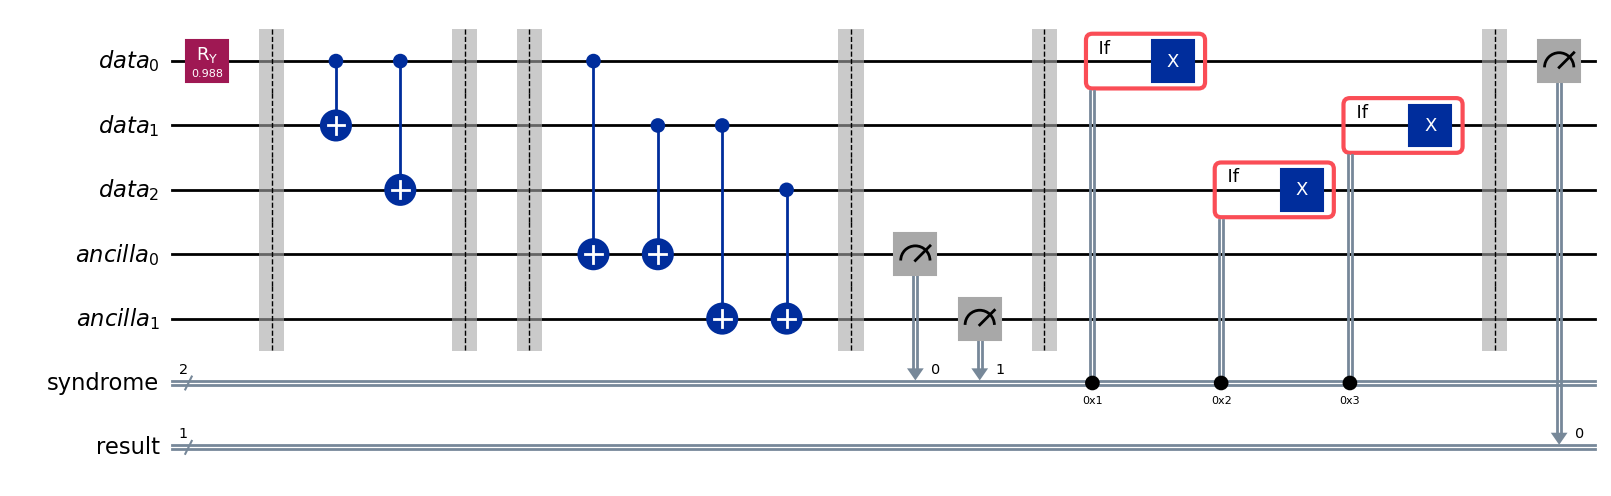

In [280]:

# ================================
# STEP 7: Final state measurement
# ================================
qc.measure(q_reg[0], c_reg_result[0])

qc.draw("mpl")


------------------------------
Theoretical P(0): 0.7751
Experimental P(0): 0.8018
Difference: 0.0266
------------------------------
Full Counts: {'0 00': 821, '1 00': 203}


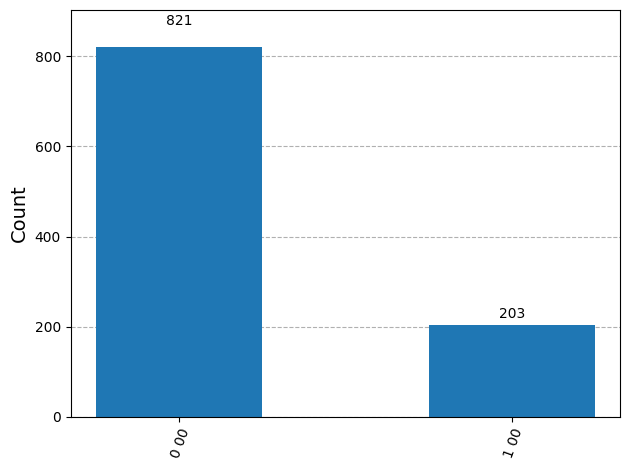

In [281]:

# =========================================
# 8. Execution & Analysis
# =========================================
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram

# transpile counts
simulator = AerSimulator()
qc_transpiled = transpile(qc, simulator)
shots = 1024
result = simulator.run(qc_transpiled, shots=1024).result()
counts = result.get_counts(qc_transpiled)


# Calculate P(0) Theoretical vs Experimental
p0_theory = (1 + u) / 2
count_0 = sum(count for key, count in counts.items() if key.split()[0] == '0')
p0_exp = count_0 / shots

print("-" * 30)
print(f"Theoretical P(0): {p0_theory:.4f}")
print(f"Experimental P(0): {p0_exp:.4f}")
print(f"Difference: {abs(p0_theory - p0_exp):.4f}")
print("-" * 30)
print(f"Full Counts: {counts}")

# Plot counts
plot_histogram(counts)